In [ ]:
import hydra
import pyrootutils
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from hydra.core.hydra_config import HydraConfig
from omegaconf import DictConfig, OmegaConf
from rich import print

from agent.loggers import ManyLoggers
from agent.utils import pylogger

pyrootutils.setup_root("..", indicator=".project-root", pythonpath=True)
log = pylogger.get_pylogger(__name__)

In [ ]:
with initialize(version_base="1.3", config_path="../configs"):
    cfg = compose(
        config_name="default_sa_eval.yaml",
        return_hydra_config=True,
        overrides=[
            "method=fs-cot-react",
            "task=gsm8k",
            "llm@agent.llm=fschat/openchat_3.5",
            "experiment_name=test",
        ],
    )

In [ ]:
print(OmegaConf.to_container(cfg.agent.llm))

In [ ]:
print(OmegaConf.to_container(cfg.agent.main_flow))

choices:
    - steps:
        - Think
        - Act
    - Act

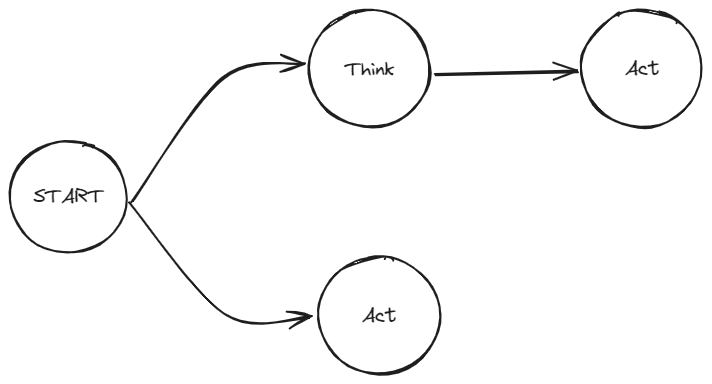

In [ ]:
logger = ManyLoggers(
    loggers=[
        hydra.utils.instantiate(logger, project_cfg=cfg, _recursive_=False)
        for logger in cfg.logger.values()
    ]
)

agent = hydra.utils.instantiate(cfg.agent, logger=logger)
task = hydra.utils.instantiate(cfg.task)

In [ ]:
agent.reset()
task.reset()

In [ ]:
agent.observe(task)

In [ ]:
while not agent.ready():
    print("Doing stuff...")
    agent.step()

In [ ]:
actions = {agent.name: agent.external_action}
rew, done = task.step(actions)

logger.log_metrics({"reward": rew, "done": done})

In [ ]:
logger.save_metrics()